<a href="https://colab.research.google.com/github/sivakumarmanoharan/GroupB_HF/blob/main/titanic_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'titanic:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3136%2F26502%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240721%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240721T180710Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6935af07a5e85401ee9b74c5d74e8f145fa4eb31a03d63a9cbe834c73f9c505ad5eab4fd3337c90f9f6c9090668f41654281d48724186128770fa2540604ea7136effac24ab1ff945a611ffedada8415b511a24572a81dcc6c6f8d41498687c9906e8f175099791425ee30234bb89ec341bc64cbda8337be6bf8db9a1c295dee88b7b5a9943bfcac4df4c5c2b8c42d28ab5cc2803ffa86a552df3f9e7afd7ec91cffbd738a85700cb0979f1397093be2eb0da36254278cdc00bb3a99f81d44d4e2acd3a4c41179a01e78801b4d8a7047e9907b5ab56fe010de46b7c187401a8338fa3474335a7d788cc4608cac0cfc15d652212fee26d7a74eb280eaa8f8a40a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [ ]:
train_path='/kaggle/input/titanic/train.csv'
test_path='/kaggle/input/titanic/test.csv'
train_data=pd.read_csv(train_path)
test_data=pd.read_csv(test_path)
print(train_data.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


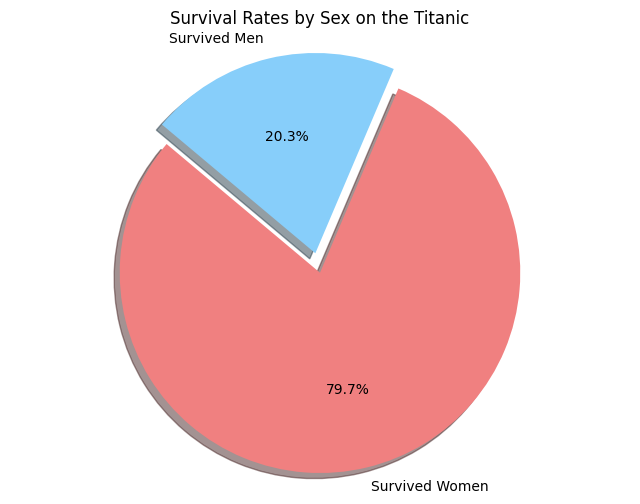

In [ ]:
# Sex vs Survival
women = train_data.loc[train_data.Sex == 'female']['Survived']
survived_women = sum(women) / len(women)

men = train_data.loc[train_data.Sex == 'male']['Survived']
survived_men = sum(men) / len(men)

# Prepare data for pie chart
labels = ['Survived Women', 'Survived Men']
sizes = [survived_women, survived_men]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode the first slice (i.e. 'Survived Women')

# Plot pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Survival Rates by Sex on the Titanic')
plt.show()



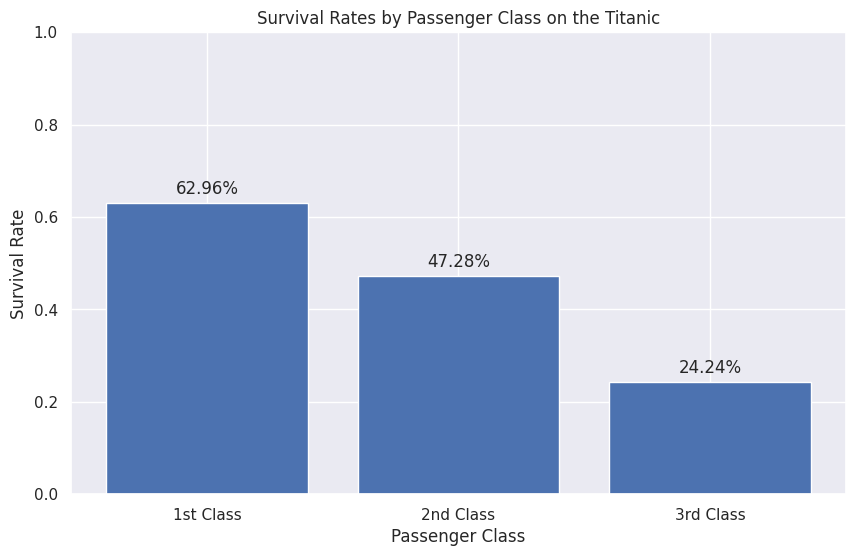

In [ ]:
# Passenger Class vs Survival
class1 = train_data.loc[train_data.Pclass == 1]['Survived']
class1_survived = sum(class1) / len(class1)

class2 = train_data.loc[train_data.Pclass == 2]['Survived']
class2_survived = sum(class2) / len(class2)

class3 = train_data.loc[train_data.Pclass == 3]['Survived']
class3_survived = sum(class3) / len(class3)

# Prepare data for bar chart
classes = ['1st Class', '2nd Class', '3rd Class']
survival_rates = [class1_survived, class2_survived, class3_survived]

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(classes, survival_rates)

plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')
plt.title('Survival Rates by Passenger Class on the Titanic')
plt.ylim(0, 1)  # Set the y-axis limit to be between 0 and 1

# Annotate bars with the survival rates
for i, rate in enumerate(survival_rates):
    plt.text(i, rate + 0.02, f'{rate:.2%}', ha='center')

plt.show()

In [ ]:
# Age Vs Survival
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


def bar_chart_age():
    names=['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80']
    bins=[0,10,20,30,40,50,60,70,80]
    age=train_data["Age"]
    age=age.dropna()
    train_data['Age_Range'] = pd.cut(age,bins,labels=names)
    sns.barplot(train_data,x='Survived', y='Age_Range', errorbar=None)





/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


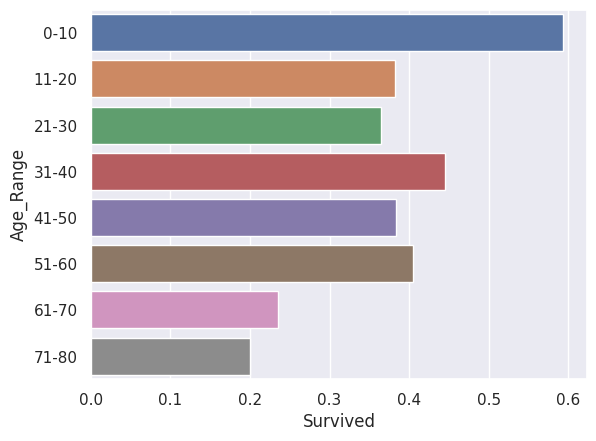

In [ ]:
bar_chart_age()